In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

datapath =  '/'.join(os.getcwd().split("\\")[:-1])+"/0_Auxiliary_Tools/"

# Simulation-based Bayesian Estimation

To improve our estimates, we need more data - which we can kind of get. We can leverage cross-user information using Bayesian methods even if we only observe very few datapoints per user. We can very easily set mixing distributions to each of the parameters of our Hawkes model, but how do we actually estimate it?

Nothing is going to be conjugate no matter what, so we won't be able to estimate the posterior distributions analytically. Crucially, we can still compute the likelihood very easily. Whenever we find ourselves in that situation, we can estimate the posterior by simulation using sampling methods. 

Commonly, we do this by Markov Chain Monte Carlo variants. These have the benefit of eventually yielding a correct (i.e. arbitrarily close to actual distribution) approximation. They are also in general very slow.

There are many new methods to speed things up. Here I use the No U-Turn Sampler (NUTS), which is a Hamiltonian Monte Carlo method.

The workings of each step are too complex to describe briefly here, but we have black-box implementations for most of them. Below is a functional example of the estimator on our complete data. For simplicity, as a first step we can estimate the constant baseline model. The main difficulty in adapting our previous code is that we must rewrite the model for tensors.

In [2]:
# we'll need pyro and torch for this
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# load data
dataframe = pd.read_csv(datapath + "Unidi_Sample.csv",index_col=0)
data = []
for i in dataframe["ID"]:
    timing_string = dataframe[dataframe["ID"]==i]["Observations"][0]
    timing_string = timing_string.split(" ")[1:-1]
    timing_string =[time.strip().strip('') for time in timing_string]
    timeseries = torch.tensor([float(k) for k in list(filter(None,timing_string))])
    data.append(timeseries)

'''
Define the Hawkes process building blocks in torch
'''

class exp_kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
    def density(self,t,history):
        history_deltas = t.reshape(-1,1) - history
        timing_mask = history_deltas>0
        raw = self.α*torch.exp(-self.β*(history_deltas*timing_mask))
        return torch.sum(raw*timing_mask,axis=1)   
    def cumulative(self,T,history):
        return torch.sum((self.α/self.β)*(1-torch.exp(-self.β*(T-history))))
    
class constant_baseline:
    def __init__(self,mu):
        self.mu = mu
    def density(self,t):
        return self.mu*torch.ones(t.reshape(-1,1).shape[0])
    def cumulative(self,T,t):
        return self.mu*T    

class Hawkes():
    def __init__(self,baseline,kernel,T):
        self.baseline = baseline
        self.kernel = kernel
        self.T = T
    def log_prob(self, t):
        safety = 1e-9
        h = self.baseline.density(t) + self.kernel.density(t,t)
        H = self.baseline.cumulative(self.T,t) + self.kernel.cumulative(self.T,t)
        ll = torch.sum(torch.log(safety + h)) - H
        return ll

'''
Fit the model at a high level to get hyperparameters
'''
def model(data):
    # set starting values for hyperparameters
    hyperparams = pyro.sample("Hyperparameters", dist.Gamma(torch.ones(6),torch.ones(6)))
    # set mixing distributions; all parameters are >0 so use gamma for starters 
    # split user-level hierarchy
    with pyro.plate("Users",len(data)):
        μ = pyro.sample('μ',dist.Gamma(hyperparams[0],hyperparams[1]))
        α = pyro.sample('α',dist.Gamma(hyperparams[2],hyperparams[3]))
        β = pyro.sample('β',dist.Gamma(hyperparams[4],hyperparams[5]))
        
    for i in pyro.plate("Obs", len(data)):
        process = Hawkes(constant_baseline(μ[i]),exp_kernel([α[i],β[i]]),360) # load model
        pyro.sample('Hawkes_{}'.format(i), process,obs=data[i]) # get likelihood
        
'''
Run the sampler proper
'''
kernel = NUTS(model, adapt_step_size=True)
posterior = MCMC(kernel, num_samples=200, warmup_steps=200)
posterior.run(data)
samples = posterior.get_samples()

Sample: 100%|███████████████████████████████████████| 400/400 [2:31:46, 22.77s/it, step size=1.00e-01, acc. prob=0.885]


It takes a while to get even small samples. But does that improve our estimates to any extent? We can plot our estimated prior distributions against the actual prior distributions used to simulate the dataset.

Estimated mixing distributions


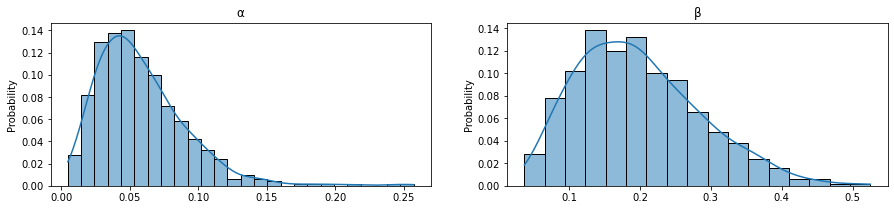

Actual mixing distributions


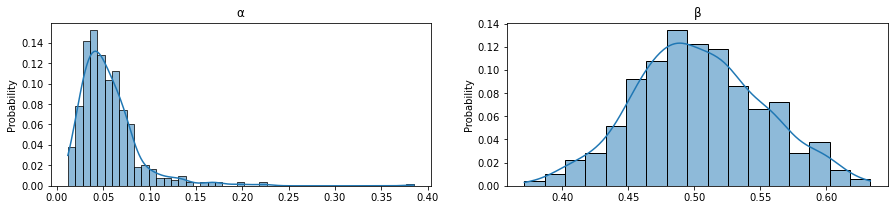

In [3]:
'''
Plot the mixing distributions
'''
estimated_hyperparameters = samples["Hyperparameters"].mean(0)
estimated_a = dist.Gamma(estimated_hyperparameters[2],estimated_hyperparameters[3]).sample([500])
estimated_b = dist.Gamma(estimated_hyperparameters[4],estimated_hyperparameters[5]).sample([500])

print("Estimated mixing distributions")
fig, axes = plt.subplots(1, 2,figsize=(15,3))
sns.histplot(estimated_a, ax=axes[0],kde=True,stat="probability")
axes[0].set_title("α")
sns.histplot(estimated_b, ax=axes[1],kde=True,stat="probability")
axes[1].set_title("β")
plt.show()

print("Actual mixing distributions")
actual_hyperparams = [0.05,0.5,0.5,0.1]
actual_alpha_dist = np.exp(np.random.normal(np.log(actual_hyperparams[0]),actual_hyperparams[1],500))
actual_beta_dist = np.exp(np.random.normal(np.log(actual_hyperparams[2]),actual_hyperparams[3],500))
fig, axes = plt.subplots(1, 2,figsize=(15,3))
sns.histplot(actual_alpha_dist, ax=axes[0],kde=True,stat="probability")
axes[0].set_title("α")
sns.histplot(actual_beta_dist, ax=axes[1],kde=True,stat="probability")
axes[1].set_title("β")
plt.show()

We can see that we successfully estimated something - we are not very far from the actual prior! The difference is partially because we set the incorrect baseline, but also partially because we used a different mixing distribution for estimation (Gamma) than for simulation (Log-Normal). Still, we have fared much better.

To sww how bad we still are at estimation, though, we can investigate the distribution of absolute percentage errors in the individual posteriors.

Absolute percentage errors of posterior estimates


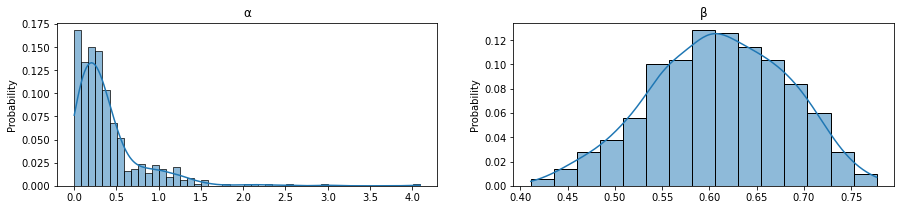

In [4]:
'''
Check accuracy of individual posteriors
'''
actual_a = []
actual_b = []
for i in dataframe["ID"]:
    actual_params= dataframe[dataframe["ID"]==i]["Params"][0]
    actual_params=actual_params.strip('[').strip(']').split(",")
    actual_a.append(float(actual_params[0]))
    actual_b.append(float(actual_params[1]))
actual_a = torch.tensor(actual_a)
actual_b = torch.tensor(actual_b)

estimated_a = samples["α"].mean(0)
estimated_b =samples["β"].mean(0)

ape_a = abs(actual_a-estimated_a)/actual_a
ape_b = abs(actual_b-estimated_b)/actual_b

fig, axes = plt.subplots(1, 2,figsize=(15,3))
print("Absolute percentage errors of posterior estimates")
sns.histplot(ape_a, ax=axes[0], kde=True, stat="probability")
sns.histplot(ape_b, ax=axes[1], kde=True, stat="probability")
axes[0].set_title("α")
axes[1].set_title("β")
plt.show()

Overall, this is not good, but we are a step closer to things working out. The pending questions are 

1) Can we find a more flexible baseline?

1) And can we do any of this faster?